# Step by Step procedures to build the Image Classification model on Kaggle
1. Select dataset of your choice and upload on Kaggle
2. Apply augmentation to the original dataset
3. Visualize the augmented dataset
4. Configure GPU
5. Build the model and start training
6. Analyze the model’s accuracy and loss

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

Define the name of project

In [4]:
project_name='zero-to-gans-course-project'

## Prepare data
Create Directories in '/kaggle/working/' path to store augmented as well as original images

In [4]:
final_data_dir = '/kaggle/working/nature-dataset'
os.mkdir(final_data_dir)
train_dir = 'train'
test_dir = 'test'
path = os.path.join(final_data_dir, train_dir)
os.mkdir(path)
path = os.path.join(final_data_dir, test_dir)
os.mkdir(path)

In [5]:
train_cls_dir0 = 'Cloud'
train_cls_dir1 = 'Rain'
train_cls_dir2 = 'Shine'
train_cls_dir3 = 'Sunrise'

path = os.path.join(final_data_dir, train_dir, train_cls_dir0)
os.mkdir(path)
path = os.path.join(final_data_dir, train_dir, train_cls_dir1)
os.mkdir(path)
path = os.path.join(final_data_dir, train_dir, train_cls_dir2)
os.mkdir(path)
path = os.path.join(final_data_dir, train_dir, train_cls_dir3)
os.mkdir(path)

In [6]:
test_cls_dir0 = 'Cloud'
test_cls_dir1 = 'Rain'
test_cls_dir2 = 'Shine'
test_cls_dir3 = 'Sunrise'

path = os.path.join(final_data_dir, test_dir, test_cls_dir0)
os.mkdir(path)
path = os.path.join(final_data_dir, test_dir, test_cls_dir1)
os.mkdir(path)
path = os.path.join(final_data_dir, test_dir, test_cls_dir2)
os.mkdir(path)
path = os.path.join(final_data_dir, test_dir, test_cls_dir3)
os.mkdir(path)

Import required libraries to perform augmentation

In [7]:
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
ia.seed(4)

In [8]:
# Data Augmentation: Create a Copy of Original Dataset by applying below transformations
seq = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)), 
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.AdditiveGaussianNoise(scale=(2, 10)),
    iaa.ElasticTransformation(alpha=90, sigma=11),
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))
    ], random_order=True)

# load traing and testing images for Augmentation 

path = '../input/weatherdataset/nature-dataset'
for folder in os.listdir(path):
    i = 0
    print('------------------------------------------------', folder ,'------------------------------------------------')
    for cls in os.listdir(path + '/' + folder):
        for imgs in os.listdir(path + '/' + folder + '/' + cls):
            try:
                img = imageio.imread(path + '/' + folder + '/' + cls + '/' + imgs)
                img_aug = seq.augment_image(img)
                imageio.imwrite(os.path.join(final_data_dir, folder + '/' + cls + '/' + 'Aug-' + cls +"%03d.png" % (i,)), img_aug)
                imageio.imwrite(os.path.join(final_data_dir, folder + '/' + cls + '/' + 'Orig-' + cls +"%03d.png" % (i,)), img)
            
            except:
                print('Error Occured in Image:', imgs)
                print('xxx',imgs, 'successfully bypassed in', cls, 'xxx')
            
            i += 1
        print('**********',cls,'Complete!','**********')

------------------------------------------------ train ------------------------------------------------
Error Occured in Image: shine131.jpg
xxx shine131.jpg successfully bypassed in Shine xxx
********** Shine Complete! **********
********** Cloud Complete! **********
********** Sunrise Complete! **********
Error Occured in Image: rain141.jpg
xxx rain141.jpg successfully bypassed in Rain xxx
********** Rain Complete! **********
------------------------------------------------ test ------------------------------------------------
********** Shine Complete! **********
********** Cloud Complete! **********
********** Sunrise Complete! **********
********** Rain Complete! **********


In [9]:
# Data transforms (normalization & data augmentation)
train_tfms = tt.Compose([tt.Resize((128,128)), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor()]) 
valid_tfms = tt.Compose([tt.Resize((128,128)), tt.ToTensor()])

In [10]:
# PyTorch datasets
data_dir = '/kaggle/working/nature-dataset'
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)
len(train_ds),len(valid_ds)

(1802, 444)

Next, we can create data loaders for retrieving images in batches. We'll use a batch size of 64 to utlize a larger portion of the GPU RAM. You can try increasing the batch size & restarting the kernel till you face an "out of memory" error.

In [11]:
batch_size = 64

In [12]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

Let's take a look at some sample images from the training dataloader.

In [15]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

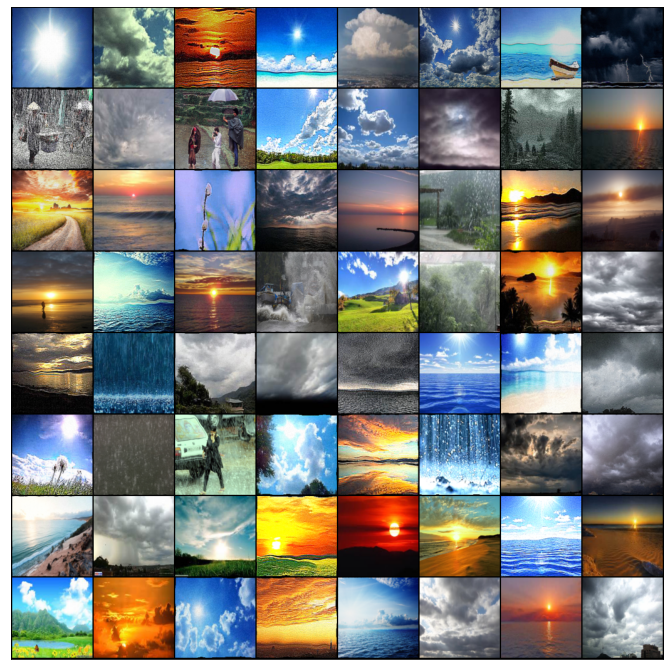

In [16]:
show_batch(train_dl)

The colors seem out of place because of the normalization. Note that normalization is also applied during inference. If you look closely, you can see the cropping and reflection padding in some of the images. Horizontal flip is a bit difficult to detect from visual inspection.

## Using a GPU

To seamlessly use a GPU, there is a need for helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required.

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [18]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

This seeming small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer. 

Go through the following blog posts to learn more:

* Why and how residual blocks work: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
* Batch normalization and dropout explained: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

We will use the ResNet architecture, as described in [this blog series](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) 


In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [21]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Weather_model(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 32, pool=True)
        self.conv2 = conv_block(32, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
        
        self.conv3 = conv_block(64, 128, pool=True)
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv4 = conv_block(128, 256, pool=True)
        self.conv5 = conv_block(256, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                        nn.Flatten(), 
                                        nn.Linear(2048, 128),
                                        nn.Linear(128, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.res2(out) + out
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

In [22]:
model = to_device( Weather_model(3, 4), device )
model

Weather_model(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-0

## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.373801827430725, 'val_acc': 0.40625}]

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. You can learn more about optimizers here: https://ruder.io/optimizing-gradient-descent/index.html

In [27]:
epochs = 8
max_lr = 0.01
grad_clip = 0.5
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [28]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00383, train_loss: 0.8443, val_loss: 1.3332, val_acc: 0.7038
Epoch [1], last_lr: 0.00934, train_loss: 0.7149, val_loss: 9.3410, val_acc: 0.3805
Epoch [2], last_lr: 0.00972, train_loss: 0.6623, val_loss: 2.9161, val_acc: 0.3063
Epoch [3], last_lr: 0.00812, train_loss: 0.4622, val_loss: 2.0811, val_acc: 0.4714
Epoch [4], last_lr: 0.00556, train_loss: 0.5460, val_loss: 0.8578, val_acc: 0.7746
Epoch [5], last_lr: 0.00283, train_loss: 0.5733, val_loss: 0.6375, val_acc: 0.7512
Epoch [6], last_lr: 0.00077, train_loss: 0.4163, val_loss: 0.4089, val_acc: 0.8625
Epoch [7], last_lr: 0.00000, train_loss: 0.3621, val_loss: 0.3690, val_acc: 0.8835
CPU times: user 6.85 s, sys: 2.72 s, total: 9.57 s
Wall time: 4min 11s


In [29]:
%%time
epochs = 8
max_lr = 0.001
grad_clip = 0.5
weight_decay = 1e-4
opt_func = torch.optim.Adam

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00038, train_loss: 0.3139, val_loss: 0.3695, val_acc: 0.8637
Epoch [1], last_lr: 0.00093, train_loss: 0.2918, val_loss: 0.3734, val_acc: 0.8669
Epoch [2], last_lr: 0.00097, train_loss: 0.3308, val_loss: 0.3550, val_acc: 0.9021
Epoch [3], last_lr: 0.00081, train_loss: 0.2807, val_loss: 0.4420, val_acc: 0.8391
Epoch [4], last_lr: 0.00056, train_loss: 0.2525, val_loss: 0.3853, val_acc: 0.8608
Epoch [5], last_lr: 0.00028, train_loss: 0.2096, val_loss: 0.2471, val_acc: 0.9197
Epoch [6], last_lr: 0.00008, train_loss: 0.2237, val_loss: 0.2708, val_acc: 0.9055
Epoch [7], last_lr: 0.00000, train_loss: 0.1705, val_loss: 0.2615, val_acc: 0.9116
CPU times: user 6.89 s, sys: 2.69 s, total: 9.58 s
Wall time: 4min 11s


In [30]:
train_time='8:22'

Our model trained to over **91% accuracy in just 8 minutes**! Try playing around with the data augmentations, network architecture & hyperparameters to achive the following results:

Let's plot the valdation set accuracies to study how the model improves over time.

In [31]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

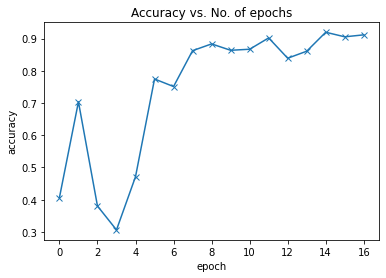

In [32]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [33]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

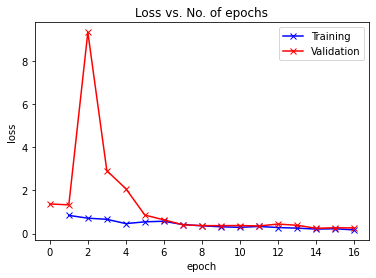

In [34]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet. Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [35]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

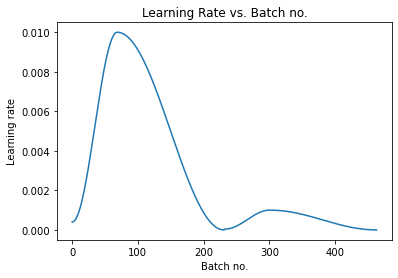

In [36]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of `0.01`, and then gradually decreases to a very small value.

## Save and Commit

Let's save the weights of the model, record the hyperparameters, and commit our experiment to Jovian. As you try different ideas, make sure to record every experiment so you can look back and analyze the results.

In [37]:
torch.save(model.state_dict(), 'weather-resnet.pth')

In [1]:
!pip install jovian --upgrade --quiet

In [2]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/rahulgupta291093/zero-to-gans-course-project


<IPython.core.display.Javascript object>

## Summary and Further Reading

Here's a summary of the different techniques used in this tutorial to improve our model performance and reduce the training time:


* **Data normalization**: We normalized the image tensors by subtracting the mean and dividing by the standard deviation of pixels across each channel. Normalizing the data prevents the pixel values from any one channel from disproportionately affecting the losses and gradients. [Learn more](https://medium.com/@ml_kid/what-is-transform-and-transform-normalize-lesson-4-neural-networks-in-pytorch-ca97842336bd)

* **Data augmentation**: We applied random transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. [Learn more](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/)

* **Residual connections**: One of the key changes to our CNN model was the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers. We used the ResNet9 architecture [Learn more](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec).

* **Batch normalization**: After each convolutional layer, we added a batch normalization layer, which normalizes the outputs of the previous layer. This is somewhat similar to data normalization, except it's applied to the outputs of a layer, and the mean and standard deviation are learned parameters. [Learn more](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd)

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are [many strategies](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) for varying the learning rate during training, and we used the "One Cycle Learning Rate Policy". [Learn more](https://sgugger.github.io/the-1cycle-policy.html)

* **Weight Decay**: We added weight decay to the optimizer, yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. [Learn more](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab)

* **Gradient clipping**: We also added gradient clippint, which helps limit the values of gradients to a small range to prevent undesirable changes in model parameters due to large gradient values during training.  [Learn more.](https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48#63e0)

* **Adam optimizer**: Instead of SGD (stochastic gradient descent), we used the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. There are many other optimizers to choose froma and experiment with. [Learn more.](https://ruder.io/optimizing-gradient-descent/index.html)


As an exercise, you should try applying each technique independently and see how much each one affects the performance and training time. As you try different experiments, you will start to cultivate the intuition for picking the right architectures, data augmentation & regularization techniques.
